<a href="https://colab.research.google.com/github/farhanwadia/EEGClassification/blob/master/EEG_Classification_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG Classification Model Training

## 1. Clone the GitHub Repository

In [ ]:
!git clone https://github.com/farhanwadia/EEGClassification
!cd EEGClassification && git checkout Farhan

#Change the working directory to the EEGClassification folder 
%cd EEGClassification
!pwd

Cloning into 'EEGClassification'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 10593 (delta 19), reused 2 (delta 0), pack-reused 10538
Receiving objects: 100% (10593/10593), 3.97 GiB | 25.43 MiB/s, done.
Resolving deltas: 100% (529/529), done.
Checking out files: 100% (10468/10468), done.
Branch 'Farhan' set up to track remote branch 'Farhan' from 'origin'.
Switched to a new branch 'Farhan'
/content/EEGClassification
/content/EEGClassification


### Imports

In [ ]:
#!pip install mne

import numpy as np
import os
#import mne
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import pickle

import csv
import json
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

## 2. Split data into training, validation, and test sets

In [ ]:
def loadCSV(filename):
    # Takes in a string of the csv file name where the EEG data is (# of measurements by 4 channels)
    # Returns the data as an np array, transposed, with all values /10**6
    data = np.loadtxt(filename, delimiter=',')
    data = data.T / 10**6
    return data

def jsonToNp(pathToJSON):
    with open(pathToJSON, "r") as f:
        data = np.array(json.load(f))
    return data 

def getFiles(parentPath):
    # Returns all files in the folder and its subfolders as a list
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(parentPath):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    return listOfFiles

def createDataset(openFiles, closedFiles):
    n = len(openFiles) + len(closedFiles)
    w = loadCSV(openFiles[0]).shape[0]
    h = loadCSV(openFiles[0]).shape[1]

    X = np.zeros((n, w, h))
    y = np.zeros((n))
    filenames = []

    # Put files into np arrays. 
    #Assumes all data has already been cut to correct lengths, with no inconsistincies in the numper of data points between files
    i = 0
    for lst in [openFiles, closedFiles]:
        for file in lst:
            data = loadCSV(file)
            X[i] = data
            if lst == openFiles:
                y[i] = 1            #Label 1: Open
            else:
                y[i] = 0            #Label 0: Closed

            name = file.split(r"\\")[-1].split(".")[0]
            filenames.append(name)
            i = i+1
    return X, y, filenames

def createDatasetFromJSON(openFiles, closedFiles):
    n = len(openFiles) + len(closedFiles)
    c = jsonToNp(openFiles[0]).shape[0]
    h = jsonToNp(openFiles[0]).shape[1]
    w = jsonToNp(openFiles[0]).shape[2]

    X = np.zeros((n, c, h, w))
    y = np.zeros((n))
    filenames = []
    
    # Put files into np arrays.
    i = 0
    for lst in [openFiles, closedFiles]:
        for file in lst:
            data = jsonToNp(file)
            X[i] = data
            if lst == openFiles:
                y[i] = 1            #Label 1: Open
            else:
                y[i] = 0            #Label 0: Closed

            name = file.split(r"\\")[-1].split(".")[0]
            filenames.append(name)
            i = i+1
    return X, y, filenames


def shuffleDataset(X, y, filenames):
    indices = np.arange(X.shape[0])
    seed = 21 
    np.random.seed(seed)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    filenames = np.array(filenames)
    filenames = filenames[indices]
    return X, y, filenames

def splitDataset(X, y, filenames, percent_train):
    n = X.shape[0]
    X_train = X[:int(percent_train*n)]
    X_val = X[int(percent_train*n):]
    y_train = y[:int(percent_train*n)]
    y_val = y[int(percent_train*n):]
    filenames_train = filenames[:int(percent_train*n)]
    filenames_val = filenames[int(percent_train*n):]
    return X_train, y_train, filenames_train, X_val, y_val, filenames_val

### Time Series

#### 5s

In [ ]:
openPath = os.getcwd() + r"//Nov 2020 Filtered Data//5s//OPEN//"
closedPath = os.getcwd() + r"//Nov 2020 Filtered Data//5s//CLOSE//"
openPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//5s//OPEN//"
closedPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//5s//CLOSE//"
openFiles = getFiles(openPath) + getFiles(openPath2)
closedFiles = getFiles(closedPath) + getFiles(closedPath2) 

X, y, filenames = createDataset(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X_train, y_train, filenames_train, X_other, y_other, filenames_other = splitDataset(X, y, filenames, percent_train=0.7)
X_val, y_val, filenames_val, X_test, y_test, filenames_test = splitDataset(X_other, y_other, filenames_other, percent_train=0.5) 

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)

X_train Shape:  (350, 4, 1280)
y_train Shape:  (350,)
X_val Shape:  (75, 4, 1280)
y_val Shape:  (75,)


Print the filenames for each dataset (verify with testing notebook after)

In [ ]:
print(filenames_train)

['/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//SD_T5 Open (valve)_(1) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//FW2_T38 Close (valve) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//CLOSE//CJ_T9 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//AZ_T38 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//FW_T12 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//CJ2_T2 Close (valve) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//OPEN//AZ_T39 Open (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//FW3_T16 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//CJ_T35 Open (valve)_(2) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//OPEN//FW_T75 Open (valve) - Filtered'
 '/content/EEGClassi

In [ ]:
print(filenames_val)

['/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//SD_T15 Open (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//CJ_T24 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//FW2_T32 Close (valve) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//CLOSE//SD_T15 Close (valve) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//CLOSE//FW_T16 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//CJ_T17 Open (valve)_(2) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//CJ_T34 Close (valve)_(1) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//OPEN//AZ_T34 Open (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//JP_T3 Open (valve) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//OPEN//SD_T30 Open (valve) - Filtered'
 '/content/EEGClassifi

In [ ]:
print(filenames_test)

['/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//CJ_T36 Close (valve) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//OPEN//SD_T17 Open (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//JP_T15 Open (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//FW3_T39 Open (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//FW2_T30 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//AZ_T35 Open (valve) - Filtered'
 '/content/EEGClassification//Nov 2020 Filtered Data//5s//CLOSE//CJ_T75 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//FW2_T20 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//CLOSE//JP_T16 Close (valve) - Filtered'
 '/content/EEGClassification//Feb 2021 Filtered Data//5s//OPEN//SD_T21 Open (valve) - Filtered'
 '/content/EEGClassificatio

#### 2 x 3.5s

In [ ]:
openPath = os.getcwd() + r"//Nov 2020 Filtered Data//2x3_5s//OPEN//"
closedPath = os.getcwd() + r"//Nov 2020 Filtered Data//2x3_5s//CLOSE//"
openPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//2x3_5s//OPEN//"
closedPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//2x3_5s//CLOSE//"
openFiles = getFiles(openPath) + getFiles(openPath2)
closedFiles = getFiles(closedPath) + getFiles(closedPath2) 

X, y, filenames = createDataset(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X2_train, y2_train, filenames2_train, X_other, y_other, filenames_other = splitDataset(X, y, filenames, percent_train=0.7)
X2_val, y2_val, filenames2_val, X2_test, y2_test, filenames2_test = splitDataset(X_other, y_other, filenames_other, percent_train=0.5) 

print("X2_train Shape: ", X2_train.shape)
print("y2_train Shape: ", y2_train.shape)
print("X2_val Shape: ", X2_val.shape)
print("y2_val Shape: ", y2_val.shape)

X2_train Shape:  (700, 4, 896)
y2_train Shape:  (700,)
X2_val Shape:  (150, 4, 896)
y2_val Shape:  (150,)


### Frequency Domain

Due to frequency domain models having the worst accuracies in the initial training on only the Nov 2020 data, they are not considered here for further analysis.

### Time-Frequency (Wavelets Transformed)

#### 5s

In [ ]:
openPath = os.getcwd() + r"//Nov 2020 Filtered Data//5s//Spectograms//OPEN//"
closedPath = os.getcwd() + r"//Nov 2020 Filtered Data//5s//Spectograms//CLOSE//"
openPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//5s//Spectograms//OPEN//"
closedPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//5s//Spectograms//CLOSE//"
openFiles = getFiles(openPath) + getFiles(openPath2)
closedFiles = getFiles(closedPath) + getFiles(closedPath2) 

X, y, filenames = createDatasetFromJSON(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X_train_wv, y_train_wv, filenames_train_wv, X_other, y_other, filenames_other = splitDataset(X, y, filenames, percent_train=0.7)
X_val_wv, y_val_wv, filenames_val_wv, X_test_wv, y_test_wv, filenames_test_wv = splitDataset(X_other, y_other, filenames_other, percent_train=0.5) 

print("X_train_wv Shape: ", X_train_wv.shape)
print("y_train_wv Shape: ", y_train_wv.shape)
print("X_val_wv Shape: ", X_val_wv.shape)
print("y_val_wv Shape: ", y_val_wv.shape)

X_train_wv Shape:  (350, 4, 60, 1280)
y_train_wv Shape:  (350,)
X_val_wv Shape:  (75, 4, 60, 1280)
y_val_wv Shape:  (75,)


#### 2 x 3.5s

In [ ]:
openPath = os.getcwd() + r"//Nov 2020 Filtered Data//2x3_5s//Spectograms//OPEN//"
closedPath = os.getcwd() + r"//Nov 2020 Filtered Data//2x3_5s//Spectograms//CLOSE//"
openPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//2x3_5s//Spectograms//OPEN//"
closedPath2 = os.getcwd() + r"//Feb 2021 Filtered Data//2x3_5s//Spectograms//CLOSE//"
openFiles = getFiles(openPath) + getFiles(openPath2)
closedFiles = getFiles(closedPath) + getFiles(closedPath2) 

X, y, filenames = createDatasetFromJSON(openFiles, closedFiles)
X, y, filenames = shuffleDataset(X, y, filenames)
X2_train_wv, y2_train_wv, filenames2_train_wv, X_other, y_other, filenames_other = splitDataset(X, y, filenames, percent_train=0.7)
X2_val_wv, y2_val_wv, filenames2_val_wv, X2_test_wv, y2_test_wv, filenames2_test_wv = splitDataset(X_other, y_other, filenames_other, percent_train=0.5) 

print("X2_train_wv Shape: ", X2_train_wv.shape)
print("y2_train_wv Shape: ", y2_train_wv.shape)
print("X2_val_wv Shape: ", X2_val_wv.shape)
print("y2_val_wv Shape: ", y2_val_wv.shape)

X2_train_wv Shape:  (700, 4, 60, 896)
y2_train_wv Shape:  (700,)
X2_val_wv Shape:  (150, 4, 60, 896)
y2_val_wv Shape:  (150,)


## 3. Time Series Baseline Models
As a baseline, try using a linear SVM and some non-linear SVMs with different amounts of regularization to try and classify the data

In [ ]:
def get_accuracy_svm(model, X, y):
    predictions = model.predict(X)
    num_correct = np.sum((predictions - y) == 0)
    n = X.shape[0]
    accuracy = num_correct/n
    print("The number of correct predictions is: ", num_correct)
    print("The number of files is: ", n)
    print("The accuracy is: ", accuracy)

### 5s

In [ ]:
# Stack channels and datapoints into one dimension for sklearn to work
X_train_svm = X_train.reshape(X_train.shape[0], 4*(256*5))
X_val_svm = X_val.reshape(X_val.shape[0], 4*(256*5))

# Fit the models
# Nonlinear model 1 has a higher regularization (1) than model 2 (1/10)
# Higher regularization helps to increase variance and reduce overfitting   
model_linear = svm.LinearSVC()
model_linear.fit(X_train_svm, y_train)

model_nonlinear_1 = svm.SVC(kernel='sigmoid', C=1)
model_nonlinear_1.fit(X_train_svm, y_train)

model_nonlinear_2 = svm.SVC(kernel='sigmoid', C=10)
model_nonlinear_2.fit(X_train_svm, y_train)

model_nonlinear_3 = svm.SVC(kernel='sigmoid', C=100)
model_nonlinear_3.fit(X_train_svm, y_train)

model_nonlinear_4 = svm.SVC(kernel='rbf', C=1)
model_nonlinear_4.fit(X_train_svm, y_train)

model_nonlinear_5 = svm.SVC(kernel='rbf', C=10)
model_nonlinear_5.fit(X_train_svm, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Linear Model

Linear Model 

Training Accuracy
The number of correct predictions is:  178
The number of files is:  350
The accuracy is:  0.5085714285714286

Validation Accuracy
The number of correct predictions is:  37
The number of files is:  75
The accuracy is:  0.49333333333333335
The shape of the coefficients vector is:  (5120,)
The intercept of the hyperplane is:  [-0.01712113] 



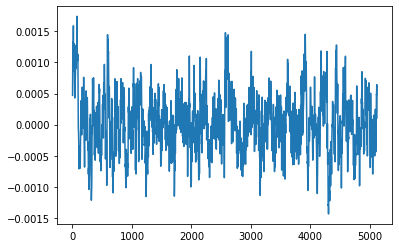

In [ ]:
# Linear model accuracies
print("Linear Model \n")
print("Training Accuracy")
get_accuracy_svm(model_linear, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_linear, X_val_svm, y_val)

# Linear model coefficients
coefs = model_linear.coef_[0]
intercept = model_linear.intercept_
#print("The coefficients of the hyperplane are: ", coefs)
print("The shape of the coefficients vector is: ", coefs.shape)
print("The intercept of the hyperplane is: ", intercept, "\n")

#Plot the coefficients of the linear SVM
x = np.array(range(1, len(coefs)+1))
plt.plot(x, coefs)
plt.show()

#### Non-Linear Models

In [ ]:
#Non-Linear Model 1 Accuracies
print("\nNon-Linear Model 1 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_1, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_1, X_val_svm, y_val)

#Non-Linear Model 2 Accuracies
print("\nNon-Linear Model 2 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_2, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_2, X_val_svm, y_val)

#Non-Linear Model 3 Accuracies
print("\nNon-Linear Model 3 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_3, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_3, X_val_svm, y_val)

#Non-Linear Model 4 Accuracies
print("\nNon-Linear Model 4 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_4, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_4, X_val_svm, y_val)

#Non-Linear Model 5 Accuracies
print("\nNon-Linear Model 5 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_5, X_train_svm, y_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_5, X_val_svm, y_val)


Non-Linear Model 1 

Training Accuracy
The number of correct predictions is:  252
The number of files is:  350
The accuracy is:  0.72

Validation Accuracy
The number of correct predictions is:  42
The number of files is:  75
The accuracy is:  0.56

Non-Linear Model 2 

Training Accuracy
The number of correct predictions is:  252
The number of files is:  350
The accuracy is:  0.72

Validation Accuracy
The number of correct predictions is:  44
The number of files is:  75
The accuracy is:  0.5866666666666667

Non-Linear Model 3 

Training Accuracy
The number of correct predictions is:  258
The number of files is:  350
The accuracy is:  0.7371428571428571

Validation Accuracy
The number of correct predictions is:  47
The number of files is:  75
The accuracy is:  0.6266666666666667

Non-Linear Model 4 

Training Accuracy
The number of correct predictions is:  323
The number of files is:  350
The accuracy is:  0.9228571428571428

Validation Accuracy
The number of correct predictions is:  42

### 2 x 3.5s

In [ ]:
# Stack channels and datapoints into one dimension for sklearn to work
X_train_svm = X2_train.reshape(X2_train.shape[0], 4*int(256*3.5))
X_val_svm = X2_val.reshape(X2_val.shape[0], 4*int(256*3.5))

# Fit the models
# Nonlinear model 1 has a higher regularization (1) than model 2 (1/10)
# Higher regularization helps to increase variance and reduce overfitting   
model_linear = svm.LinearSVC()
model_linear.fit(X_train_svm, y2_train)

model_nonlinear_1 = svm.SVC(kernel='sigmoid')
model_nonlinear_1.fit(X_train_svm, y2_train)

model_nonlinear_2 = svm.SVC(kernel='sigmoid', C=10)
model_nonlinear_2.fit(X_train_svm, y2_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Linear Model

Linear Model 

Training Accuracy
The number of correct predictions is:  367
The number of files is:  700
The accuracy is:  0.5242857142857142

Validation Accuracy
The number of correct predictions is:  77
The number of files is:  150
The accuracy is:  0.5133333333333333
The shape of the coefficients vector is:  (3584,)
The intercept of the hyperplane is:  [-0.04853466] 



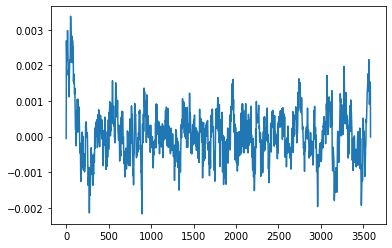

In [ ]:
# Linear model accuracies
print("Linear Model \n")
print("Training Accuracy")
get_accuracy_svm(model_linear, X_train_svm, y2_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_linear, X_val_svm, y2_val)

# Linear model coefficients
coefs = model_linear.coef_[0]
intercept = model_linear.intercept_
#print("The coefficients of the hyperplane are: ", coefs)
print("The shape of the coefficients vector is: ", coefs.shape)
print("The intercept of the hyperplane is: ", intercept, "\n")

#Plot the coefficients of the linear SVM
x = np.array(range(1, len(coefs)+1))
plt.plot(x, coefs)
plt.show()

#### Non-Linear Models

In [ ]:
#Non-Linear Model 1 Accuracies
print("\nNon-Linear Model 1 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_1, X_train_svm, y2_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_1, X_val_svm, y2_val)

#Non-Linear Model 2 Accuracies
print("\nNon-Linear Model 2 \n")
print("Training Accuracy")
get_accuracy_svm(model_nonlinear_2, X_train_svm, y2_train)
print("\nValidation Accuracy")
get_accuracy_svm(model_nonlinear_2, X_val_svm, y2_val)


Non-Linear Model 1 

Training Accuracy
The number of correct predictions is:  413
The number of files is:  700
The accuracy is:  0.59

Validation Accuracy
The number of correct predictions is:  77
The number of files is:  150
The accuracy is:  0.5133333333333333

Non-Linear Model 2 

Training Accuracy
The number of correct predictions is:  436
The number of files is:  700
The accuracy is:  0.6228571428571429

Validation Accuracy
The number of correct predictions is:  64
The number of files is:  150
The accuracy is:  0.4266666666666667


### Discussion
The best model so far seems to be with 5s data using nonlinear model 3, which was a SVM using sigmoid kernel and regularization of 1/100. The validation accuracy for this model was 63%, which is the benchmark that any deep learning model should exceed. 

In [ ]:
# Saving model to file
filename = 'svm_kernel-sigmoid_C-100_5s.sav'
pickle.dump(model_nonlinear_3, open(filename, 'wb'))
 

In [ ]:
# some time later...
# load the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_svm, Y_test_svm)
print(result)

## 4. Deep Learning Models

### Training Code

In [ ]:
torch.manual_seed(21) # set the random seed

def createTensorDataset(data, labels):
    # Returns a tensor dataset object given np arrays of the data and labels
    data_tensor = torch.tensor(data)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(data_tensor, labels_tensor)
    return dataset

def addDimensionForCNNModels(dataset):
# Takes in a pytorch dataset with data of size [N, C, H]
# Returns a pytorch dataset with data of size [N, 1, C, H]
# This allows us to treat the multiple EEG channnels like a 2D image of 1 channel
    data = dataset.tensors[0]
    labels = dataset.tensors[1]
    data = torch.unsqueeze(data, 1)
    return TensorDataset(data, labels)

def downsampleTensorHW(dataset, factor):
    # Given a tensor dataset of data, labels, takes data of shape [N, C, H, W]
    # Returns the dataset, but with data of shape [N, C, H/factor, W/factor]
    data = dataset.tensors[0]
    labels = dataset.tensors[1]
    data_new = F.interpolate(data, size=(int(data.shape[-2] /factor), int(data.shape[-1] /factor)), mode='bicubic', align_corners=False)
    return TensorDataset(data_new, labels)

def get_accuracy(model, data_loader, train=False, use_cuda=True):
    correct = 0
    total = 0
    for file, labels in iter(data_loader):
        file = file.float()
        labels = labels.long()
        if use_cuda and torch.cuda.is_available():
            file = file.cuda()
            labels = labels.cuda()
        output = model(file)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += file.shape[0]
    return correct / total

def plot_training_curve(iters, losses, train_acc, val_acc):
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Maximum Training Accuracy: {}".format(max(train_acc)))
    print("Maximum Validation Accuracy: {}".format(max(val_acc)))

In [ ]:
def train(model, train_dataset, val_dataset, batch_size=100, num_epochs=1, learning_rate=0.01, momen=0.9, use_cuda=True, use_adam=True, save_weights=True):
    # Create folder to save the weights in
    now = datetime.now()
    folder_name = model.name + ' Weights ' + now.strftime("%Y-%m-%d %H-%M")
    save_path = os.getcwd() + "//" + folder_name + "//"
    if save_weights and not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Make dataloader objects to iterate over
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    #Define loss functions and optimizer
    criterion = nn.CrossEntropyLoss()
    if use_adam:
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momen)

    iters, losses, train_acc, val_acc = [], [], [], []
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for file, labels in iter(train_loader):
            
            file = file.float()
            labels = labels.long()
            if use_cuda and torch.cuda.is_available():
                file = file.cuda()
                labels = labels.cuda()
            
            out = model(file)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader, train=False))  # compute validation accuracy
            print("Iteration: ", str(n), "| Train Loss: ", losses[n], "| Train Accuracy: ", train_acc[n], "| Validation Accuracy: ", val_acc[n])
            n += 1
            model_path = "model_{0}_bs{1}_lr{2}_epoch{3}_iteration{4}_val-acc{5}".format(model.name, 
                                                                                         batch_size, 
                                                                                         str(learning_rate).replace('.', '-'), 
                                                                                         epoch, n, str(round(val_acc[-1]*100, 4)).replace('.', '-'))
            if save_weights:
                if val_acc[-1] == max(val_acc) and val_acc.count(val_acc[-1]) == 1:
                    torch.save(model.state_dict(), save_path + model_path + ".pth") #save weights at new maximum for validation accuracy
    if save_weights:
        torch.save(model.state_dict(), save_path + model_path + ".pth") #Save the very last iteration
        #Write the train loss and train/val accuracies to CSV file
        epochs = np.arange(1, num_epochs + 1)
        np.savetxt(save_path + "{}_train_loss.csv".format(model_path), losses)
        np.savetxt(save_path + "{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt(save_path + "{}_val_acc.csv".format(model_path), val_acc) 

    # plotting
    plot_training_curve(iters, losses, train_acc, val_acc)

### Model Architectures

#### Time Series

In [ ]:
class ANN_TS_2L(nn.Module):
    def __init__(self):
        super(ANN_TS_2L, self).__init__()
        self.name = "ANN_TS_2L"
        self.layer1 = nn.Linear((256*5)*4, 200)
        self.layer2 = nn.Linear(200, 50)
        self.layer3 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, (256*5)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

class ANN_TS2_2L(nn.Module):
    def __init__(self):
        super(ANN_TS2_2L, self).__init__()
        self.name = "ANN_TS2_2L"
        self.layer1 = nn.Linear(int(256*3.5)*4, 200)
        self.layer2 = nn.Linear(200, 50)
        self.layer3 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, int(256*3.5)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

class ANN_TS_3L(nn.Module):
    def __init__(self):
        super(ANN_TS_3L, self).__init__()
        self.name = "ANN_TS_3L"
        self.layer1 = nn.Linear((256*5)*4, 500)
        self.layer2 = nn.Linear(500, 200)
        self.layer3 = nn.Linear(200, 50)
        self.layer4 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, (256*5)*4)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

#### Time-Frequency

In [ ]:
class CNN_WV(nn.Module):
    def __init__(self):
        super(CNN_WV, self).__init__()
        self.name = "CNN_WV"
        
        self.conv1 = nn.Conv2d(4, 8, 4) #in_channels, out_channels (# of kernels to try), kernel_size. Size in is 4x30x640
        self.pool = nn.MaxPool2d(2, 2) #kernel_size (for the pool), stride. Size in should be 8x26x636 
        self.conv2 = nn.Conv2d(8, 16, 4) #size in should be 8x13x318
        self.pool = nn.MaxPool2d(2, 2) # size in should be 16x9x314
        
        self.fc1 = nn.Linear(16*5*157, 2500) #size in should be 16x5x157
        self.fc2 = nn.Linear(2500, 500)
        self.fc3 = nn.Linear(500, 50)
        self.fc4 = nn.Linear(50, 2)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flatten the input

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        x = x.squeeze(1)
        return x

class CNN2_WV(nn.Module):
    def __init__(self):
        super(CNN2_WV, self).__init__()
        self.name = "CNN2_WV"
        
        self.conv1 = nn.Conv2d(4, 8, 4) #in_channels, out_channels (# of kernels to try), kernel_size. Size in is 4x30x448
        self.pool = nn.MaxPool2d(2, 2) #kernel_size (for the pool), stride. Size in should be 8x26x444 
        self.conv2 = nn.Conv2d(8, 16, 4) #size in should be 8x13x222
        self.pool = nn.MaxPool2d(2, 2) # size in should be 16x9x218
        
        self.fc1 = nn.Linear(16*5*109, 2000) #size in should be 16x5x109
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, 50)
        self.fc4 = nn.Linear(50, 2)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flatten the input

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        x = x.squeeze(1)
        return x

### Training

#### Time Series Models

##### 5s

In [ ]:
train_dataset = createTensorDataset(X_train, y_train)
val_dataset = createTensorDataset(X_val, y_val)

Iteration:  0 | Train Loss:  0.013867669105529785 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  1 | Train Loss:  0.01394626498222351 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  2 | Train Loss:  0.013866736888885497 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  3 | Train Loss:  0.01386300563812256 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  4 | Train Loss:  0.013856523036956787 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  5 | Train Loss:  0.013967663049697876 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  6 | Train Loss:  0.013789061307907104 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  7 | Train Loss:  0.013879748582839966 | Train Accuracy:  0.5085714

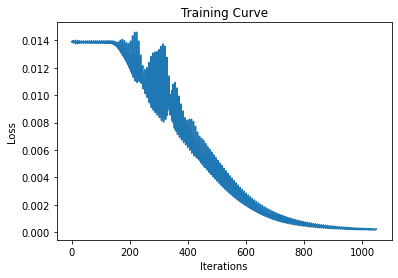

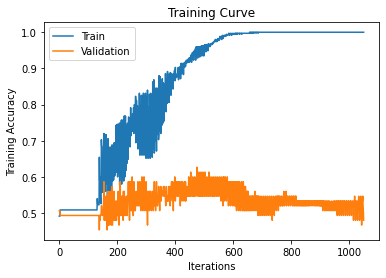

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.48
Maximum Training Accuracy: 1.0
Maximum Validation Accuracy: 0.6266666666666667


In [ ]:
model = ANN_TS_2L()
train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=150, learning_rate = 0.01, momen = 0.7, use_adam = True, save_weights=True)

Iteration:  0 | Train Loss:  0.013847697973251343 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  1 | Train Loss:  0.013943192958831787 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  2 | Train Loss:  0.013874461650848388 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  3 | Train Loss:  0.013870998620986938 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  4 | Train Loss:  0.013886497020721436 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  5 | Train Loss:  0.013785279989242553 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  6 | Train Loss:  0.013964804410934449 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  7 | Train Loss:  0.013853031396865844 | Train Accuracy:  0.49142

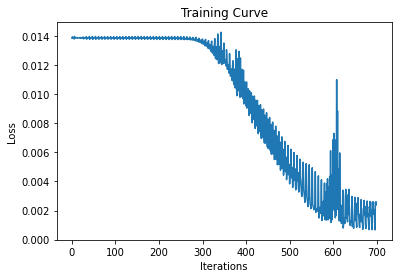

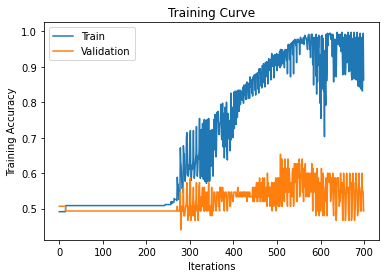

Final Training Accuracy: 0.8628571428571429
Final Validation Accuracy: 0.49333333333333335
Maximum Training Accuracy: 0.9971428571428571
Maximum Validation Accuracy: 0.6533333333333333


In [ ]:
model = ANN_TS_3L()
train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=100, learning_rate = 0.001, momen = 0.4, use_adam = True, save_weights=True)

Iteration:  0 | Train Loss:  0.009313767751057942 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  1 | Train Loss:  0.009224606355031332 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  2 | Train Loss:  0.009262767632802328 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  3 | Train Loss:  0.009241723219553629 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  4 | Train Loss:  0.009318497975667318 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  5 | Train Loss:  0.009235340754191081 | Train Accuracy:  0.49142857142857144 | Validation Accuracy:  0.5066666666666667
Iteration:  6 | Train Loss:  0.009242260456085205 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  7 | Train Loss:  0.009252349535624186 | Train Accuracy:  0.50857

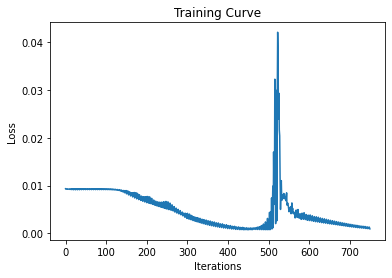

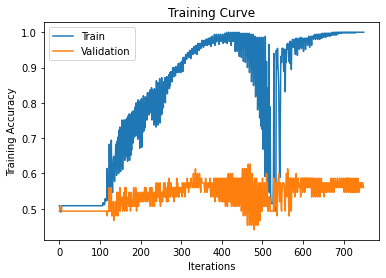

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.56
Maximum Training Accuracy: 1.0
Maximum Validation Accuracy: 0.6266666666666667


In [ ]:
model = ANN_TS_2L()
train(model, train_dataset, val_dataset, batch_size = 75, num_epochs=150, learning_rate = 0.01, momen = 0.8, use_adam = True, save_weights=True)

Iteration:  0 | Train Loss:  0.013924005031585694 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  1 | Train Loss:  0.013850003480911255 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  2 | Train Loss:  0.013864932060241699 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  3 | Train Loss:  0.013865151405334473 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  4 | Train Loss:  0.013854248523712158 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  5 | Train Loss:  0.013937231302261353 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  6 | Train Loss:  0.013844608068466187 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  7 | Train Loss:  0.013868027925491333 | Train Accuracy:  0.50857

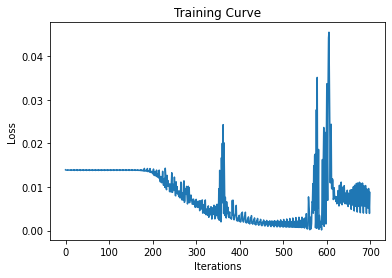

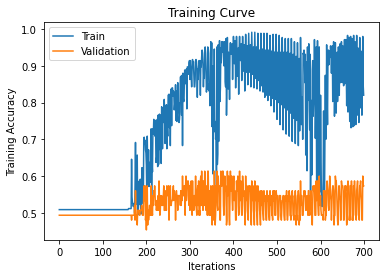

Final Training Accuracy: 0.82
Final Validation Accuracy: 0.5733333333333334
Maximum Training Accuracy: 0.9914285714285714
Maximum Validation Accuracy: 0.6133333333333333


In [ ]:
model = ANN_TS_3L()
train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=100, learning_rate = 0.005, momen = 0.7, use_adam = True, save_weights=True)

##### 2 x 3.5s

In [ ]:
train_dataset = createTensorDataset(X2_train, y2_train)
val_dataset = createTensorDataset(X2_val, y2_val)

Iteration:  0 | Train Loss:  0.014112745523452758 | Train Accuracy:  0.4757142857142857 | Validation Accuracy:  0.4866666666666667
Iteration:  1 | Train Loss:  0.013828034400939942 | Train Accuracy:  0.4757142857142857 | Validation Accuracy:  0.4866666666666667
Iteration:  2 | Train Loss:  0.01386417269706726 | Train Accuracy:  0.4757142857142857 | Validation Accuracy:  0.4866666666666667
Iteration:  3 | Train Loss:  0.013863334655761719 | Train Accuracy:  0.4757142857142857 | Validation Accuracy:  0.4866666666666667
Iteration:  4 | Train Loss:  0.013864535093307494 | Train Accuracy:  0.5242857142857142 | Validation Accuracy:  0.5133333333333333
Iteration:  5 | Train Loss:  0.013804484605789185 | Train Accuracy:  0.5242857142857142 | Validation Accuracy:  0.5133333333333333
Iteration:  6 | Train Loss:  0.013847728967666626 | Train Accuracy:  0.5242857142857142 | Validation Accuracy:  0.5133333333333333
Iteration:  7 | Train Loss:  0.01416388750076294 | Train Accuracy:  0.52428571428571

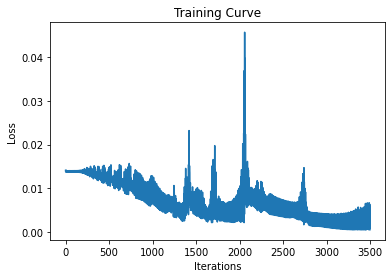

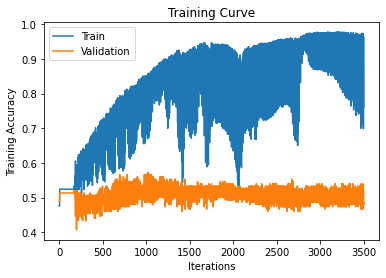

Final Training Accuracy: 0.76
Final Validation Accuracy: 0.52
Maximum Training Accuracy: 0.9771428571428571
Maximum Validation Accuracy: 0.5733333333333334


In [ ]:
model = ANN_TS2_2L()
train(model, train_dataset, val_dataset, batch_size = 50, num_epochs=150, learning_rate = 0.01, momen = 0.7, use_adam = True, save_weights=True)

#### Time-Frequency Domain Models

##### 5s

In [ ]:
train_dataset = createTensorDataset(X_train_wv, y_train_wv)
val_dataset = createTensorDataset(X_val_wv, y_val_wv)

#Downsample the height and width to make training easier
train_dataset = downsampleTensorHW(train_dataset, 2)
val_dataset = downsampleTensorHW(val_dataset, 2)

Iteration:  0 | Train Loss:  0.0344363272190094 | Train Accuracy:  0.4828571428571429 | Validation Accuracy:  0.5066666666666667
Iteration:  1 | Train Loss:  0.03526872396469116 | Train Accuracy:  0.4857142857142857 | Validation Accuracy:  0.5066666666666667
Iteration:  2 | Train Loss:  0.03467753529548645 | Train Accuracy:  0.4942857142857143 | Validation Accuracy:  0.52
Iteration:  3 | Train Loss:  0.035622885823249816 | Train Accuracy:  0.5028571428571429 | Validation Accuracy:  0.52
Iteration:  4 | Train Loss:  0.0345097541809082 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.5333333333333333
Iteration:  5 | Train Loss:  0.03390579223632813 | Train Accuracy:  0.5314285714285715 | Validation Accuracy:  0.52
Iteration:  6 | Train Loss:  0.034937348961830136 | Train Accuracy:  0.5171428571428571 | Validation Accuracy:  0.52
Iteration:  7 | Train Loss:  0.03477916717529297 | Train Accuracy:  0.5285714285714286 | Validation Accuracy:  0.52
Iteration:  8 | Train Loss:  0

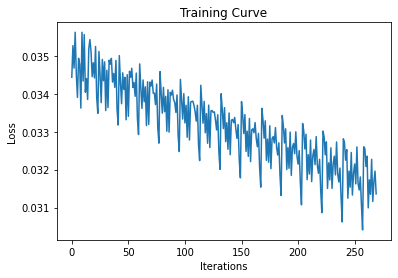

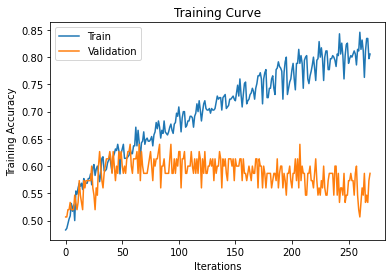

Final Training Accuracy: 0.8057142857142857
Final Validation Accuracy: 0.5866666666666667
Maximum Training Accuracy: 0.8457142857142858
Maximum Validation Accuracy: 0.64


In [ ]:
model = CNN_WV()
train(model, train_dataset, val_dataset, batch_size = 20, num_epochs=15, learning_rate = 0.00025, momen = 0.4, use_adam = False, save_weights=True)

In [ ]:
model = CNN_WV()
train(model, train_dataset, val_dataset, batch_size = 20, num_epochs=15, learning_rate = 0.0003, momen = 0.4, use_adam = False, save_weights=True)

Iteration:  0 | Train Loss:  0.03468606173992157 | Train Accuracy:  0.4942857142857143 | Validation Accuracy:  0.49333333333333335
Iteration:  1 | Train Loss:  0.03460254967212677 | Train Accuracy:  0.4942857142857143 | Validation Accuracy:  0.49333333333333335
Iteration:  2 | Train Loss:  0.034476035833358766 | Train Accuracy:  0.5028571428571429 | Validation Accuracy:  0.49333333333333335
Iteration:  3 | Train Loss:  0.03520435094833374 | Train Accuracy:  0.5028571428571429 | Validation Accuracy:  0.49333333333333335
Iteration:  4 | Train Loss:  0.03423711657524109 | Train Accuracy:  0.5028571428571429 | Validation Accuracy:  0.49333333333333335
Iteration:  5 | Train Loss:  0.03477444648742676 | Train Accuracy:  0.5085714285714286 | Validation Accuracy:  0.49333333333333335
Iteration:  6 | Train Loss:  0.0345884770154953 | Train Accuracy:  0.5057142857142857 | Validation Accuracy:  0.49333333333333335
Iteration:  7 | Train Loss:  0.03470664620399475 | Train Accuracy:  0.5057142857142

KeyboardInterrupt: ignored

##### 2 x 3.5s

In [ ]:
train_dataset = createTensorDataset(X_train2_wv, y_train2_wv)
val_dataset = createTensorDataset(X_val2_wv, y_val2_wv)

#Downsample the height and width to make training easier
train_dataset = downsampleTensorHW(train_dataset, 2)
val_dataset = downsampleTensorHW(val_dataset, 2)

print("Train Data Shape: ", train_dataset.tensors[0].shape)
print("Train Labels Shape: ", train_dataset.tensors[1].shape)

In [ ]:
model = CNN2_WV()
train(model, train_dataset, val_dataset, batch_size = 15, num_epochs=15, learning_rate = 0.0005, momen = 0.55, use_adam = True, save_weights=True)